# 2. Natural Language Processing

This notebook preprocesses and develops pipelines to classify posts from the two subreddits using classification models.

**Preprocessing and Modeling**
- Is text data successfully converted to a matrix representation?
- Are methods such as stop words, stemming, and lemmatization explored?
- Does the student properly split and/or sample the data for validation/training purposes?
- Does the student test and evaluate a variety of models to identify a production algorithm (**AT MINIMUM:** two classification models, **BONUS:** try a Naive Bayes)?
- Does the student defend their choice of production model relevant to the data at hand and the problem?
- Does the student explain how the model works and evaluate its performance successes/downfalls?

#### Imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, recall_score, precision_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

In [62]:
%store -r stop_words

In [63]:
df = pd.read_csv('../datasets/combined_cleaned.csv',na_filter=False)

#### Make train and test sets out of the train data

In [64]:
X = df[['selftext','title']]
y = df['subreddit']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,stratify=y)

In [66]:
y_test.value_counts()

Divorce            997
weddingplanning    987
Name: subreddit, dtype: int64

In [67]:
print(f'Baseline accuracy is {round(y_test.value_counts()[0]*100/len(y_test),1)}%.')

Baseline accuracy is 50.3%.


#### Encode subreddit

In [68]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [69]:
pd.DataFrame(y_test_enc).value_counts()

0    997
1    987
dtype: int64

Classes legend:
- 0: Divorce
- 1: WeddingPlanning

#### Create Lemmatizer

In [70]:
def lemma_tokenizer(doc):  ## Used class notes
    wnl = WordNetLemmatizer()
    return [w for w in word_tokenize(doc)]

### Pipelines

#### Logistic Regression Pipeline

In [71]:
cv1 = CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=4,max_df=0.4,strip_accents='unicode')
ct1 = make_column_transformer(
    (cv1,'selftext'),
    (cv1,'title')
)

In [72]:
# First pass
pipe_lr = Pipeline([
    ('ct', ct1),
    ('lr', LogisticRegression(max_iter = 10_000,random_state=42))
])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train), pipe_lr.score(X_test, y_test)

(0.9954614220877458, 0.9732862903225806)

GridSearch

In [73]:
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'lr', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__verbose_feature_names_out', 'ct__countvectorizer-1', 'ct__countvectorizer-2', 'ct__countvectorizer-1__analyzer', 'ct__countvectorizer-1__binary', 'ct__countvectorizer-1__decode_error', 'ct__countvectorizer-1__dtype', 'ct__countvectorizer-1__encoding', 'ct__countvectorizer-1__input', 'ct__countvectorizer-1__lowercase', 'ct__countvectorizer-1__max_df', 'ct__countvectorizer-1__max_features', 'ct__countvectorizer-1__min_df', 'ct__countvectorizer-1__ngram_range', 'ct__countvectorizer-1__preprocessor', 'ct__countvectorizer-1__stop_words', 'ct__countvectorizer-1__strip_accents', 'ct__countvectorizer-1__token_pattern', 'ct__countvectorizer-1__tokenizer', 'ct__countvectorizer-1__vocabulary', 'ct__countvectorizer-2__analyzer', 'ct__countvectorizer-2__binary', 'ct__countvectorizer-2__decode_error', 'ct__countvectorizer-2__dt

In [74]:
params = {
    # 'ct__countvectorizer-1__ngram_range':[(1,1),(1,2),(1,3),(1,4)],
    # 'ct__countvectorizer-1__min_df':np.arange(2,7),
    # 'lr__C': [1/20, 1/10, 1/5, 1/2, 1, 5],
    # 'ct__countvectorizer-1__max_df': [0.4,0.6,0.8,0.9,0.95,1.0],
    # 'cv__strip_accents': [None,'ascii', 'unicode'],
    # 'ct__countvectorizer-1__tokenizer': [None,lemma_tokenizer]
}

gs_lr = GridSearchCV(
    pipe_lr, param_grid=params,n_jobs=-1)

gs_lr.fit(X_train,y_train_enc);

In [75]:
gs_lr.best_params_

{}

In [76]:
gs_lr.best_score_

0.9652031577980225

In [77]:
pd.DataFrame(gs_lr.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [78]:
pd.DataFrame(gs_lr.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
0,4.66949,{},0.965203,0.005178,1


I will feed this back into my model.

I will feed the results back into my model. Results:
- best_params = {'cv__min_df': 4, 'cv__ngram_range': (1, 3)} for params = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4)],
    'cv__min_df':np.arange(2,7)
}
- best_params = {'lr__C': 0.5} with no impact for max_df for params = {
    'lr__C': 'lr__C': [1/20, 1/10, 1/5, 1/2, 1, 5],
    'ct__countvectorizer-1__max_df': [0.4,0.6,0.8,0.9,0.95,1.0],
    }
    *note, the accuracy went down when changing to 1/2, so I kept with default
  
- best_params = {'cv__strip_accents': 'unicode'} (actually tie with None, but quicker) for params = {
    'cv__strip_accents': [None,'ascii', 'unicode']
}
- best_params = 'cv__tokenizer': None} for params = {
    'cv__tokenizer': [None,lemma_tokenizer]
}

#### Decision Tree Pipeline

In [80]:
pipe_dt = Pipeline([
    ('ct', ct1),
    ('dt', DecisionTreeClassifier(max_depth=None,criterion='entropy',min_samples_split=3,random_state=42))
])
pipe_dt.fit(X_train, y_train)
pipe_dt.score(X_train, y_train), pipe_dt.score(X_test, y_test)

(0.996301899478904, 0.9395161290322581)

In [81]:
# params_dt = {
#      'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
# }

# gs_dt = GridSearchCV(pipe_dt, param_grid = params_dt, n_jobs=-1)

# gs_dt.fit(X_train,y_train_enc);

# gs_dt.best_params_

# gs_dt.best_score_

# gs_dt.cv_results_

I will feed the results back into my model. Results:
- best_params = {'dt__criterion': 'entropy'} for params_dt = {
    'dt__criterion': ["gini", "entropy"]
}
- best_params = {'dt__criterion': 'entropy', 'dt__min_samples_split': 4} for params_dt = {
    'dt__criterion': ["gini", "entropy"],
    'dt__min_samples_split': [2,4,6],
}
- best_params = {'dt__criterion': 'entropy', 'dt__min_samples_split': 3} for params_dt = {
    'dt__criterion': ["entropy"],
    'dt__min_samples_split': [3,4,5],
}
- best_params = {'cv__min_df': 4, 'cv__ngram_range': (1, 2)} for params_dt = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9) 
}
- best_params = {'cv__max_df': 0.5} for params_dt = {
     'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
}

#### K Nearest Neighbors Pipeline

In [82]:
pipe_knn = Pipeline([
    ('ct', ct1),
    ('knn', KNeighborsClassifier(n_neighbors=5,p=2))
     ])
pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_train, y_train), pipe_knn.score(X_test, y_test)

(0.869894099848714, 0.7741935483870968)

GridSearch

In [83]:
# params_knn = {
#     'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9) 
# }

# gs_knn = GridSearchCV(
#     pipe_knn, param_grid=params_knn,n_jobs=-1)

# gs_knn.fit(X_train,y_train_enc);

# gs_knn.best_params_

# gs_knn.best_score_

# gs_knn.cv_results_

I will feed the results back into my model. Results:
- best_params = {'knn__n_neighbors': 5} for params_knn = {'knn__n_neighbors':np.arange(2,15)}
- best_params = {'knn__n_neighbors': 5, 'knn__p': 2} for params_knn = {
    'knn__n_neighbors':np.arange(3,7),
    'knn__p': [1,2]
}
- no impact for params_knn = {
     'cv__max_df': [0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
}
- best_params = {'cv__min_df': 3, 'cv__ngram_range': (1, 1)} for params_knn = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9) 
}

#### Random Forest Pipeline

In [84]:
pipe_rf = Pipeline([
    ('ct', ct1),
    ('rf', RandomForestClassifier(max_depth=None,n_estimators=500,random_state=42))
])
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

(0.9978147587829888, 0.9637096774193549)

In [85]:
# params_rf = {
#     'cv__min_df':np.arange(7,11)
# }

# gs_rf = GridSearchCV(pipe_rf, param_grid = params_rf, n_jobs=-1)

# gs_rf.fit(X_train,y_train_enc);

# gs_rf.best_params_

# gs_rf.best_score_

# gs_rf.cv_results_

I will feed the results back into my model. Results:
- best_params = {'cv__min_df': 8, 'cv__ngram_range': (1, 3)} for  'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)], 'cv__min_df':np.arange(2,9)
- best_params = {'rf__max_depth': None, 'rf__n_estimators': 500} for params_rf = {
    'rf__max_depth':[None, 1,3,5],
    'rf__n_estimators':[100,500,700]
}
- best_params = {'cv__min_df': 7} for params_rf = {
    'cv__min_df':np.arange(7,11)
}

#### Extra Trees Pipeline

In [86]:
pipe_et = Pipeline([
    ('ct', ct1),
    ('et', ExtraTreesClassifier(random_state=42))
])
pipe_et.fit(X_train, y_train)
pipe_et.score(X_train, y_train), pipe_et.score(X_test, y_test)

(0.9978147587829888, 0.9637096774193549)

In [87]:
pipe_et.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'et', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__verbose_feature_names_out', 'ct__countvectorizer-1', 'ct__countvectorizer-2', 'ct__countvectorizer-1__analyzer', 'ct__countvectorizer-1__binary', 'ct__countvectorizer-1__decode_error', 'ct__countvectorizer-1__dtype', 'ct__countvectorizer-1__encoding', 'ct__countvectorizer-1__input', 'ct__countvectorizer-1__lowercase', 'ct__countvectorizer-1__max_df', 'ct__countvectorizer-1__max_features', 'ct__countvectorizer-1__min_df', 'ct__countvectorizer-1__ngram_range', 'ct__countvectorizer-1__preprocessor', 'ct__countvectorizer-1__stop_words', 'ct__countvectorizer-1__strip_accents', 'ct__countvectorizer-1__token_pattern', 'ct__countvectorizer-1__tokenizer', 'ct__countvectorizer-1__vocabulary', 'ct__countvectorizer-2__analyzer', 'ct__countvectorizer-2__binary', 'ct__countvectorizer-2__decode_error', 'ct__countvectorizer-2__dt

In [88]:
# params_et = {
#     'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)],
#     'cv__min_df':np.arange(2,9)
# }

# gs_et = GridSearchCV(pipe_et, param_grid = params_et, n_jobs=-1)

# gs_et.fit(X_train,y_train_enc);

# gs_et.best_params_

# gs_et.best_score_

# gs_et.cv_results_

I will feed the results back into my model. Results:
- best_params = {'et__max_features': 'auto'} params_et = {
    'et__max_features':['auto', 'sqrt','log2']
}
- best_params = {'cv__min_df': 7, 'cv__ngram_range': (1, 4)} for params_et = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4)],
    'cv__min_df':np.arange(2,9)
}

#### Multinomial Naive Bayes Pipeline

In [89]:
pipe_mnb = Pipeline([
    ('ct', ct1),
    ('mnb', MultinomialNB())
])
pipe_mnb.fit(X_train, y_train)
pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

(0.9789880652210455, 0.9692540322580645)

In [90]:
# params_mnb = {
#     'mnb__alpha':[1/50,1/20,1/10]
# }

# gs_mnb = GridSearchCV(pipe_mnb, param_grid = params_mnb, n_jobs=-1)

# gs_mnb.fit(X_train,y_train_enc);

# gs_mnb.best_params_

# gs_mnb.best_score_

# gs_mnb.cv_results_

I will feed the results back into my model. Results:
- best_params = {'mnb__alpha': 0.1} for params_mnb = {
    'mnb__alpha':[1/10,1/2,1,2,5,10]
}
- best_params = {'mnb__alpha': 0.1} for params_mnb = {
    'mnb__alpha':[1/50,1/20,1/10]
}

#### Ada Boost Classifier Pipeline

In [91]:
# First pass
pipe_ab = Pipeline([
    ('ct', ct1),
    ('ab', AdaBoostClassifier(random_state=42))
])
pipe_ab.fit(X_train, y_train)
pipe_ab.score(X_train, y_train), pipe_ab.score(X_test, y_test)

(0.9290637081862498, 0.9238911290322581)

GridSearch

#### Compare scores

pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

In [92]:
list(pipe_dt.named_steps.keys())[1]

'dt'

In [93]:
pipelines = [pipe_lr, pipe_dt, pipe_knn, pipe_rf, pipe_et, pipe_mnb, pipe_ab]

In [94]:
def scores(pipe):
    print(f'{list(pipe.named_steps.keys())[1]} train score is {pipe.score(X_train,y_train)} and test score is {pipe.score(X_test,y_test)}')

for pipe in pipelines:
    scores(pipe);

lr train score is 0.9954614220877458 and test score is 0.9732862903225806
dt train score is 0.996301899478904 and test score is 0.9395161290322581
knn train score is 0.869894099848714 and test score is 0.7741935483870968
rf train score is 0.9978147587829888 and test score is 0.9637096774193549
et train score is 0.9978147587829888 and test score is 0.9637096774193549
mnb train score is 0.9789880652210455 and test score is 0.9692540322580645
ab train score is 0.9290637081862498 and test score is 0.9238911290322581


#### Compare confusion matrices

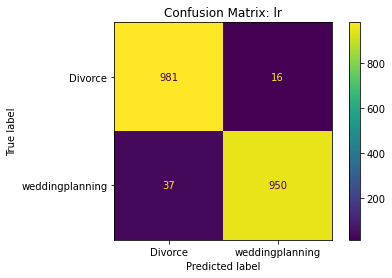

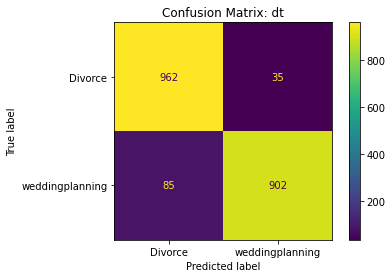

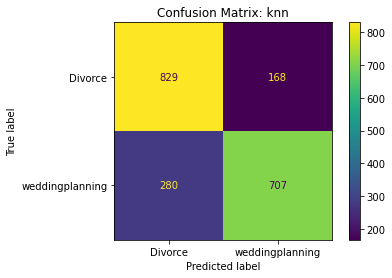

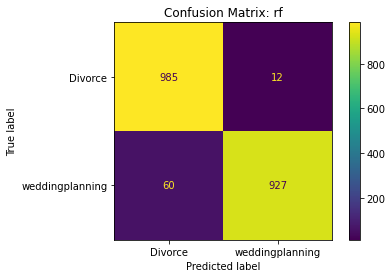

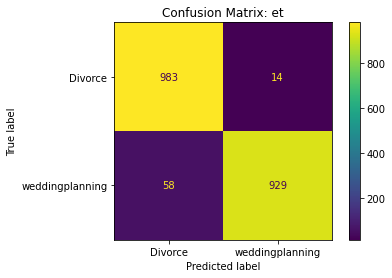

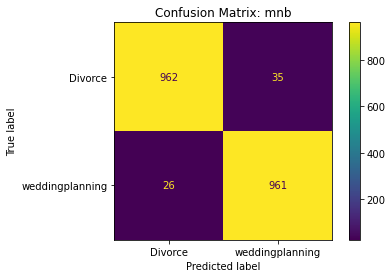

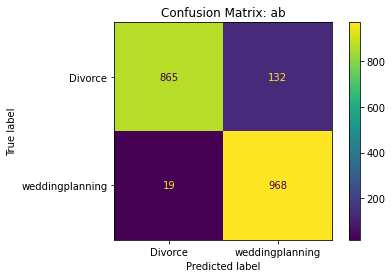

In [95]:
def confusion(pipe):
    ConfusionMatrixDisplay.from_estimator(pipe,X_test,y_test)
    plt.title(f'Confusion Matrix: {list(pipe.named_steps.keys())[1]}');

for pipe in pipelines:
    confusion(pipe);

In [96]:
misclassifications= X_test.copy()

In [97]:
misclassifications['true class'] = y_test

In [98]:
misclassifications['LR pred class'] = pipe_lr.predict(X_test)
misclassifications['DT pred class'] = pipe_dt.predict(X_test)
misclassifications['KNN pred class'] = pipe_knn.predict(X_test)
misclassifications['RF pred class'] = pipe_rf.predict(X_test)
misclassifications['ET pred class'] = pipe_et.predict(X_test)
misclassifications['MNB pred class'] = pipe_mnb.predict(X_test)
misclassifications['AB pred class'] = pipe_ab.predict(X_test)

In [128]:
df[['selftext','title']].iloc[7369,:][1]

'Can you give me a checklist of red flags to look out for ? Both during and before you get with a person..'

In [99]:
misclassifications[misclassifications['true class'] != misclassifications['LR pred class']]

,selftext,title,true class,LR pred class,DT pred class,KNN pred class,RF pred class,ET pred class,MNB pred class,AB pred class
3778,[removed],Am I in the Wrong?,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
7369,"Going through something super unexpected, and ...",Can you give me a checklist of red flags to lo...,Divorce,weddingplanning,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
2448,"I feel uncomfortable with being called a ""wife...","Anyone else not want to be referred to as ""wife""?",weddingplanning,Divorce,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,Divorce
428,[removed],No videographer,weddingplanning,Divorce,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning
508,[removed],Filing Question,weddingplanning,Divorce,Divorce,Divorce,Divorce,Divorce,Divorce,weddingplanning
4343,[removed],My internet friends please read my post,Divorce,weddingplanning,Divorce,Divorce,Divorce,Divorce,weddingplanning,weddingplanning
6249,[removed],How nervous should I (26f) be about her (24f) ...,Divorce,weddingplanning,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning
6734,[removed],Other options?,Divorce,weddingplanning,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning
4108,"Never, ever use this rip off service. Somehow...",COMPLETECASE.com,Divorce,weddingplanning,weddingplanning,Divorce,Divorce,Divorce,Divorce,weddingplanning
1506,"To start, I'm not engaged currently (Although ...",How are you guys paying for it on top of every...,weddingplanning,Divorce,weddingplanning,Divorce,weddingplanning,Divorce,weddingplanning,weddingplanning


It seems that some of the classifications could go the other way depending on the model used. Let's try a voting classifier to improve model performance.

### Voting Classifier

In [111]:
# lr train score is 0.9954614220877458 and test score is 0.9732862903225806
# dt train score is 0.996301899478904 and test score is 0.9395161290322581
# knn train score is 0.869894099848714 and test score is 0.7741935483870968
# rf train score is 0.9978147587829888 and test score is 0.9637096774193549
# et train score is 0.9978147587829888 and test score is 0.9637096774193549
# mnb train score is 0.9789880652210455 and test score is 0.9692540322580645
# ab train score is 0.9290637081862498 and test score is 0.9238911290322581


In [100]:
pipelines_names = list(zip(['lr','dt','knn','rf','et','mnb','ab'],pipelines))

In [132]:
vr1 = VotingClassifier(
    pipelines_names,
    n_jobs=-1,
    weights=[2,1,0.5,1.5,1.5,1.5,2]
)
vr1.fit(X_train,y_train);

In [133]:
vr1.score(X_train,y_train), vr1.score(X_test,y_test)


(0.9961338040006724, 0.9737903225806451)

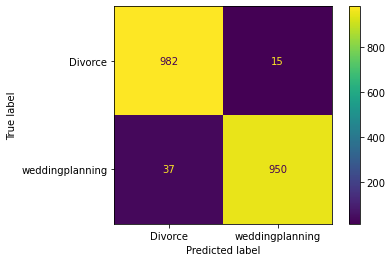

In [134]:
ConfusionMatrixDisplay.from_estimator(vr1,X_test,y_test)